In [1]:
# 1-1
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV

df = pd.read_csv('./data/student_data.csv')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1-1 EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   paid        395 non-null    object 
 3   activities  395 non-null    object 
 4   famrel      394 non-null    float64
 5   freetime    393 non-null    float64
 6   goout       392 non-null    float64
 7   Dalc        391 non-null    float64
 8   Walc        393 non-null    float64
 9   health      391 non-null    float64
 10  absences    392 non-null    float64
 11  grade       395 non-null    int64  
 12  G1          395 non-null    int64  
 13  G2          395 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 43.3+ KB


school, sex, paid, activities는 object형, 그 외 컬럼은 수치형 컬럼이다.

In [4]:
df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        1
freetime      2
goout         3
Dalc          4
Walc          2
health        4
absences      3
grade         0
G1            0
G2            0
dtype: int64

famrel, freetime, goout, Dalc, Walc, health, absences에 각각 결측치가 존재한다.

In [5]:
df.describe()

,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
count,394.000000,393.000000,392.000000,391.000000,393.000000,391.000000,392.000000,395.000000,395.000000,395.000000
mean,3.944162,3.239186,3.114796,1.470588,2.284987,3.562660,5.676020,10.660759,10.908861,10.713924
std,0.897794,0.994265,1.112397,0.873266,1.287778,1.386949,8.013393,3.719390,3.319195,3.761505
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000
25%,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,8.000000,9.000000
50%,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,13.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,19.000000


absences, grade, G1, G2를 제외한 컬럼의 값은 1~5점 만점의 데이터임을 유추해볼 수 있고, 모든 컬럼은 이산적인 형태임을 유추해볼 수 있다.

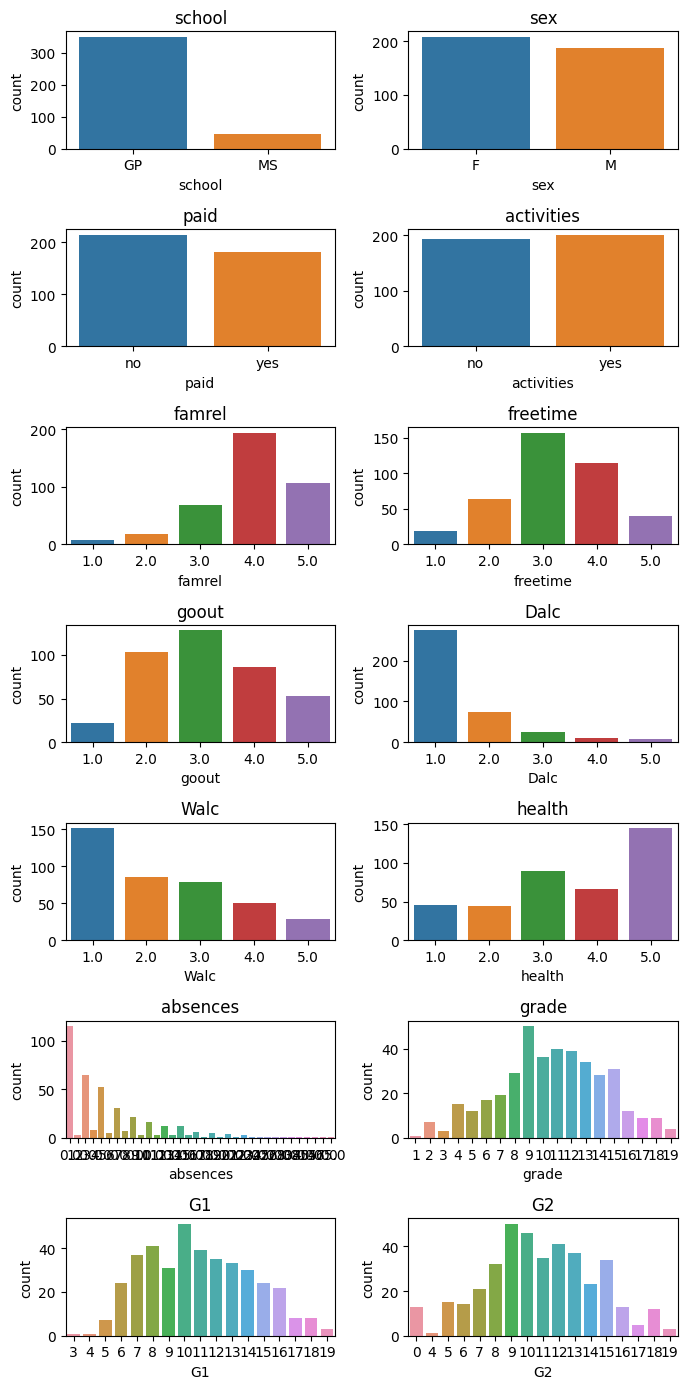

In [6]:
plt.figure(figsize=(7,14))

for idx, col in enumerate(df.columns):
    plt.subplot(7, 2, idx+1)
    plt.title(col)
    sns.countplot(x=df[col])

plt.tight_layout()
plt.show()

네 개의 object형 컬럼 중 sex 컬럼은 데이터의 분포가 매우 불균형하고, 나머지 세 개의 컬럼은 어느 정도 고르게 분포되어 있다고 볼 수 있다.

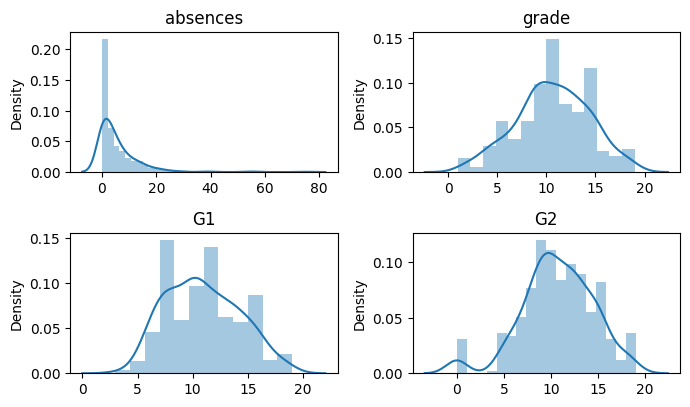

In [7]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(7,14))

for idx, col in enumerate(df.columns[-4:]):
    plt.subplot(7, 2, idx+1)
    plt.title(col)
    sns.distplot(x=df[col])

plt.tight_layout()
plt.show()

In [8]:
for col in df.columns[-4:]:
    print(f'{col} - 왜도 : {df[col].skew()} / 첨도 : {df[col].kurtosis()}')

absences - 왜도 : 3.692192300836291 / 첨도 : 21.837569332800093
grade - 왜도 : -0.13601581797905124 / 첨도 : -0.3445280032987723
G1 - 왜도 : 0.24061324337096948 / 첨도 : -0.6938295024333452
G2 - 왜도 : -0.4316453889925487 / 첨도 : 0.6277056433602413


absences를 제외한 grade, G1, G2, 는 정규분포를 따른다고 볼 수 있다.

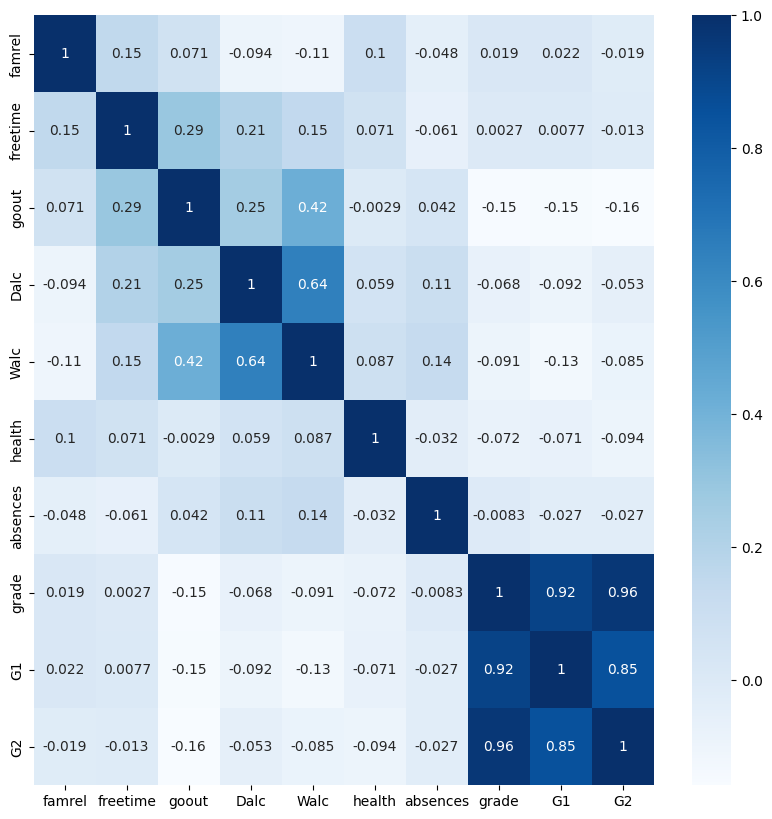

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show();

종속변수 grade는 G1, G2와 강한 양의 상관관계를 보이고 있다. 특히 G1 - G2 간에도 강한 상관성을 보이고 있으므로 다중공선성 확인이 필요하다.

EDA를 통해 object 형 컬럼들은 범주형 변수 인코딩이 필요한 것을 확인했고, grade와 G1, G2 변수 각각 강한 상관성을 보이는 것을 확인했다. 또한 7개 컬럼의 결측치를 확인했으므로 학생 성적 데이터를 분석에 활용하기 위해서는 언급된 데이터를 전처리 하는 과정이 필요하다.

### 1-2

결측치를 처리하기 위한 방안으로는 결측치 대체, 결측치 삭제가 있다.
해당 데이터에서는 대부분 결측치가 존재하는 행의 데이터 중 1개 혹은 2개의 결측치가 확인된다.
그리고 데이터의 수가 많지 않으므로 분석에 최대한 많은 데이터를 활용하기 위해
결측치 삭제보다는 결측치는 대체하는 방안으로 활용한다.

absences의 결측값은 측정이 안된 값, 즉 0으로 대체하고 나머지 결측치 값은 최빈값으로 대체한다.
absences의 0 또한 최빈값이므로 모든 컬럼 최빈값으로 대체한다.

In [10]:
na_df = df[df.isna().any(axis=1)]
na_idx = na_df.index

na_df

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
9,GP,M,yes,yes,5.0,5.0,NaN,1.0,1.0,5.0,0.0,15,14,15
14,GP,M,no,no,NaN,5.0,2.0,1.0,1.0,3.0,0.0,15,14,16
15,GP,F,no,no,4.0,4.0,4.0,1.0,2.0,2.0,NaN,14,14,14
25,GP,F,yes,no,1.0,2.0,2.0,1.0,NaN,5.0,14.0,8,6,9
39,GP,F,yes,yes,4.0,3.0,1.0,1.0,1.0,NaN,8.0,13,14,13
40,GP,F,no,yes,3.0,3.0,NaN,1.0,2.0,3.0,25.0,9,7,10
49,GP,F,no,yes,4.0,4.0,4.0,1.0,1.0,NaN,2.0,7,7,7
61,GP,F,no,yes,5.0,5.0,5.0,NaN,5.0,5.0,6.0,10,10,8
71,GP,M,no,no,3.0,3.0,3.0,NaN,1.0,3.0,0.0,10,10,10
82,GP,F,yes,no,4.0,4.0,4.0,1.0,1.0,5.0,NaN,6,7,6


In [11]:
missing_col = df.columns[4:-3]

In [12]:
for col in missing_col:
    max_counts = df[col].value_counts().index[0]
    df[col] = df[col].fillna(max_counts)
    
df.loc[na_idx]

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
9,GP,M,yes,yes,5.0,5.0,3.0,1.0,1.0,5.0,0.0,15,14,15
14,GP,M,no,no,4.0,5.0,2.0,1.0,1.0,3.0,0.0,15,14,16
15,GP,F,no,no,4.0,4.0,4.0,1.0,2.0,2.0,0.0,14,14,14
25,GP,F,yes,no,1.0,2.0,2.0,1.0,1.0,5.0,14.0,8,6,9
39,GP,F,yes,yes,4.0,3.0,1.0,1.0,1.0,5.0,8.0,13,14,13
40,GP,F,no,yes,3.0,3.0,3.0,1.0,2.0,3.0,25.0,9,7,10
49,GP,F,no,yes,4.0,4.0,4.0,1.0,1.0,5.0,2.0,7,7,7
61,GP,F,no,yes,5.0,5.0,5.0,1.0,5.0,5.0,6.0,10,10,8
71,GP,M,no,no,3.0,3.0,3.0,1.0,1.0,3.0,0.0,10,10,10
82,GP,F,yes,no,4.0,4.0,4.0,1.0,1.0,5.0,0.0,6,7,6


### 1-3 범주형 변수 인코딩

object 형 컬럼인 school, sex, paid, activities은 범주형 변수 인코딩이 필요하다. object 형태로는 머신러닝 모델에 사용할 수 없기 때문이다. 학생 성적 데이터의 object형 컬럼의 데이터는 각각 이진 데이터(두 가지)이므로 One-hot Encoding, Label Encoding 어느 것을 진행해도 0과 1의 값으로 변형된다.

In [13]:
obj_col = df.columns[:4]

for col in obj_col:
    print(f'{col}은 다음과 같이 Encoding : {dict({j:i for i, j in enumerate(df[col].unique())})}')
    df[col] = df[col].map({j:i for i, j in enumerate(df[col].unique())})
    
df

school은 다음과 같이 Encoding : {'GP': 0, 'MS': 1}
sex은 다음과 같이 Encoding : {'F': 0, 'M': 1}
paid은 다음과 같이 Encoding : {'no': 0, 'yes': 1}
activities은 다음과 같이 Encoding : {'no': 0, 'yes': 1}


,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,0,0,0,0,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,0,0,0,0,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,0,0,1,0,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,0,0,1,1,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,0,0,1,0,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,1,0,5.0,5.0,4.0,4.0,5.0,4.0,11.0,9,9,9
391,1,1,0,0,2.0,4.0,5.0,3.0,4.0,2.0,3.0,15,14,16
392,1,1,0,0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,8,10,8
393,1,1,0,0,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11,11,12


### 1-4 데이터 분할 방법

데이터 분할 방법으로는 테스트셋의 비율만 정하여 무작위로 분할하는 방법과 테스트셋과 훈련셋을 범주형 종속변수의 분포 비율과 동일하게 분할하는 stratify 방법이 있다. 학생 성적 데이터의 종속변수 grade는 순서형 범주지만, 데이터가 정규분포를 따른다고 할 수 있기때문에 연속형 데이터로 간주하고 분석을 진행한다. 따라서 무작위로 분할하는 방법을 적용한다.

In [14]:
x = df.drop(columns=['grade'])
y = df[['grade']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2024)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((276, 13), (119, 13), (276, 1), (119, 1))

훈련셋 276개, 테스트셋 119개로 분할

### 1-5 알고리즘 공통점

svm, xgboost, randomforest 모두 분류와 회귀분석에 모두 사용할 수 있는 알고리즘이다.
그러나 현재 전처리된 학생 성적 데이터는 데이터의 스케일이 다르다. 그렇기 때문에 스케일의 영향을 받지 않는 randomforest 알고리즘이 현재의 학생 성적 데이터 분석에 가장 적합하다고 할 수 있다.

In [21]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [22]:
svr = SVR()
rf = RandomForestRegressor()
xgbr = xgb.XGBRegressor()

In [23]:
models = [svr, rf, xgbr]

score = []

for model in models:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    score.append((str(model), rmse))
    
score

[('SVR()', 0.9560520319453598),
 ('RandomForestRegressor()', 0.7218079541602985),
 ("XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n             early_stopping_rounds=None, enable_categorical=False,\n             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n             grow_policy='depthwise', importance_type=None,\n             interaction_constraints='', learning_rate=0.300000012, max_bin=256,\n             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,\n             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,\n             monotone_constraints='()', n_estimators=100, n_jobs=0,\n             num_parallel_tree=1, predictor='auto', random_state=0, ...)",
  0.8867297274630118)]

세 모델의 RMSE 측정 결과 서포트 벡터 머신 모델의 RMSE가 가장 높게 나왔다. 그러므로 아무 튜닝을 하지 않은 모델을 사용할 경우 SVM을 사용한다. 그러나 SVM은 초평면이라는 경계를 통해 예측값을 계산하는 알고리즘이기 때문에 비선형 데이터에 사용하기에는 한계가 있다. 계산을 용이하게 하기 위해 초평면과 데이터의 거리인 마진을 soft(오차 허용 범위 큼), 혹은 hard(오차 허용 범위 작음)로 설정하여 조절하는 방법이 있을 수 있다.

또한 세 모델 모두 하이퍼파라미터 튜닝을 진행한다면 현재와는 결과가 달라질 수도 있다. 실제 현업에서는 신규로 데이터가 지속적으로 추가될 것을 고려하여 ML Pipeline을 개발해야하며, 처리하지 않았던 다중공선성 등을 제거하여 불필요한 변수는 제거하는 등의 추가 처리 및 모델의 설명력을 높이고, 유지하는 것이 중요하다.

### 2-1 선형 회귀 적용

In [25]:
import mglearn

In [26]:
x, y =mglearn.datasets.load_extended_boston()

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2024)

In [29]:
from sklearn.linear_model import LinearRegression

In [32]:
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

print(f'선형회귀 결정계수 : {lr.score(x_test, y_test)}, 선형회귀 RMSE : {np.sqrt(mean_squared_error(y_test, pred))}')

선형회귀 결정계수 : 0.8431220447153743, 선형회귀 RMSE : 3.889856847977547


### 2-2 릿지 회귀 적용

In [35]:
ridge_param = {'alpha' : np.arange(0, 1.1, 0.1)}

from sklearn.linear_model import Ridge

In [55]:
ridge = Ridge()
ridge.fit(x_train, y_train)

grid_ridge = GridSearchCV(cv=5, estimator=ridge, param_grid=ridge_param, return_train_score=True)

In [56]:
grid_ridge.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True)

In [57]:
grid_ridge.best_params_

{'alpha': 0.1}

In [58]:
tuned_ridge = Ridge(alpha=0.1)
tuned_ridge.fit(x_train, y_train)
pred = tuned_ridge.predict(x_test)

print(f'Ridge 결정계수 : {tuned_ridge.score(x_test, y_test)}, Ridge RMSE : {np.sqrt(mean_squared_error(y_test, pred))}')

Ridge 결정계수 : 0.8441499257267635, Ridge RMSE : 3.8770925278859094


### 3-1 다항회귀

In [60]:
from sklearn.preprocessing import PolynomialFeatures

In [61]:
poly = PolynomialFeatures(degree=3)

In [62]:
poly_train = poly.fit_transform(x_train)
poly_test = poly.transform(x_test)

In [69]:
lr = LinearRegression()

In [70]:
lr.fit(poly_train, y_train)

LinearRegression()

In [71]:
lr.predict(poly_test)  intercept_  coef_

array([ 19.74573009,  28.5596669 ,  33.46543877,  54.10584282,
        25.27466638,  25.20138294,  19.63480521,  14.67308172,
        20.25717831,  21.72035306,  23.59601834,  24.89658776,
        24.39164129,  21.97006771,  37.49241831,  27.3972429 ,
        41.30248248,  20.44288932,  29.12238714,  22.10396627,
         2.4097993 ,  42.61823785,  20.80248642,  32.30490771,
        42.16511477,  31.38810628,  36.36528423,  23.23844532,
        47.32171454,  17.17879286,  22.74539457,  65.76790435,
        22.80614292,  33.22722847,   3.09719976,  18.94575603,
        43.98621986,  32.72217593,  32.51818075,  13.04627292,
         7.69195877,  47.17131578,  21.2999451 ,  23.39612187,
        73.61122052,  41.50102524,  25.56258207,  21.46897986,
        44.06677161,  18.23069748,  11.66067831,  31.99683308,
        19.48653346,  24.12194819,  22.41711247,  41.56004113,
        25.42172167,   1.46119659,   8.74237446,  19.41535504,
        21.3881482 ,  27.21166153,  24.79020192,  21.91

-29.215383873340677

In [73]:
lr.coef_

array([ -0.07428793, -14.75616258,   6.02148167, ...,  -3.0057895 ,
        -4.50915771,   4.19146847])

### 4-1 ANOVA

In [82]:
df = pd.read_csv('./data/avocado.csv', index_col=0)

In [83]:
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


- 범주형 변수 : type
- 연속형 변수 : AveragePrice, Total olume

In [93]:
use_col = ['AveragePrice', 'type', 'region']

In [52]:
import string

# 주문서 리스트 생성 함수
def make_order_list(order_list, n):
    made_list = []
    for order in order_list:
        made_list += [order + alphabet for alphabet in string.ascii_lowercase]
        if len(made_list) > n:
            return made_list
    return made_list

def solution(n, bans):
    
    for length in range(1, 12):
        if n < 26 ** length:
            break

    order_list = list(string.ascii_lowercase)

    for idx in range(2, length + 1):
        if idx == 2:
            process = make_order_list(string.ascii_lowercase, n)
        else:
            process = make_order_list(process, n)

        order_list += process

    for ban in bans:
        try:
            order_list.remove(ban)
        except:
            continue
            
    return order_list[n-1]

In [47]:
# 주문서 글자수 확인하여 불필요한 반복 방지

In [53]:
n = 30
bans = ["d", "e", "bb", "aa", "ae"]
solution(n, bans)

'ah'

In [122]:
10 ** 15

1000000000000000

In [78]:
26 * 26 * 26

17576

In [136]:
[i + j + h for i in string.ascii_lowercase for j in string.ascii_lowercase for h in string.ascii_lowercase]

['aaa',
 'aab',
 'aac',
 'aad',
 'aae',
 'aaf',
 'aag',
 'aah',
 'aai',
 'aaj',
 'aak',
 'aal',
 'aam',
 'aan',
 'aao',
 'aap',
 'aaq',
 'aar',
 'aas',
 'aat',
 'aau',
 'aav',
 'aaw',
 'aax',
 'aay',
 'aaz',
 'aba',
 'abb',
 'abc',
 'abd',
 'abe',
 'abf',
 'abg',
 'abh',
 'abi',
 'abj',
 'abk',
 'abl',
 'abm',
 'abn',
 'abo',
 'abp',
 'abq',
 'abr',
 'abs',
 'abt',
 'abu',
 'abv',
 'abw',
 'abx',
 'aby',
 'abz',
 'aca',
 'acb',
 'acc',
 'acd',
 'ace',
 'acf',
 'acg',
 'ach',
 'aci',
 'acj',
 'ack',
 'acl',
 'acm',
 'acn',
 'aco',
 'acp',
 'acq',
 'acr',
 'acs',
 'act',
 'acu',
 'acv',
 'acw',
 'acx',
 'acy',
 'acz',
 'ada',
 'adb',
 'adc',
 'add',
 'ade',
 'adf',
 'adg',
 'adh',
 'adi',
 'adj',
 'adk',
 'adl',
 'adm',
 'adn',
 'ado',
 'adp',
 'adq',
 'adr',
 'ads',
 'adt',
 'adu',
 'adv',
 'adw',
 'adx',
 'ady',
 'adz',
 'aea',
 'aeb',
 'aec',
 'aed',
 'aee',
 'aef',
 'aeg',
 'aeh',
 'aei',
 'aej',
 'aek',
 'ael',
 'aem',
 'aen',
 'aeo',
 'aep',
 'aeq',
 'aer',
 'aes',
 'aet',
 'aeu',
